<h1> Objetive </h1>

<p> The objective is to predict the total_minutes a order takes to complete, where the rows not containing a total_minutes value should be set aside as a part of the submission file, containing the order_id with the predicted values.</p>
    
    
   
<p>As we are interested in seeing how you attacked the problem, we also ask you to include your code together with the submission file. The code needs to be well documented, explaining the decisions made. With these explanations, we will be looking at everything from how the data was processed, features used to the completed model and predictions. </p>

<h1> 1. Libraries </h1>

<p> Import libraries </p>

In [99]:
%matplotlib inline
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians, asin
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_absolute_error, mean_squared_error


<h1> 2. Import Datasets </h1>

<p> Esta sección se enfoca en cargar la data entregada, la cual viene en archivos CSV, la idea es poder generar un merge entre las distintas bases para obtener un dataset final consolidado. la variable por la cual deberían juntarse las tablas el order id. Además debemos agregar los atributos que serán las variables independientes que permitirán predecir los valores de tiempo esperado. En secciones posteriores se hará una depuración del dataset final.   </p>

<h3> 2.1 Orders dataset </h3>

In [56]:
# Load Orders
order = pd.read_csv('data1/orders.csv', sep=',')
order.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [57]:

print("Cantidad de columnas: ", order.shape[1])
print("Cantidad de filas: ", order.shape[0])
print(order.dtypes)

Cantidad de columnas:  8
Cantidad de filas:  10000
order_id            object
lat                float64
lng                float64
promised_time       object
on_demand             bool
shopper_id          object
store_branch_id     object
total_minutes      float64
dtype: object


<p> Podemos notar que la data tiene 8 atributos y 1000 datos o filas, que order_id, promised_time, shopper_id, store branch_id son objetos, mientras que el resto de columnas son números  </p>

In [58]:
# Checking for missing values
order.isnull().any()

order_id           False
lat                False
lng                False
promised_time      False
on_demand          False
shopper_id         False
store_branch_id    False
total_minutes       True
dtype: bool

<p> Vemos que la columna a predecir, total_minutes es la única columna que presenta missing values. Hay 2.000 filas con total_minutes sin valor.  </p>

In [59]:
# Sum missing values total time
order.total_minutes.isnull().sum()

2000

In [60]:
order.total_minutes.describe()

count    8000.000000
mean       81.106130
std        34.720837
min        11.969489
25%        55.225480
50%        74.731672
75%       100.273498
max       304.190303
Name: total_minutes, dtype: float64

<p> Se aprecia que los valores de la variable a predecir, total_minutes varían entre 12 y 304 minutos, con una median de 74 minutos y un promedio de 81 minutos   </p>

<h3> 2.2 Shoppers </h3>

In [61]:
# Import shoppers dataset
shoppers = pd.read_csv('data1/shoppers.csv', sep=',')
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [62]:
print("Cantidad de columnas: ", shoppers.shape[1])
print("Cantidad de filas: ", shoppers.shape[0])
print(shoppers.dtypes)

Cantidad de columnas:  6
Cantidad de filas:  2864
shopper_id        object
seniority         object
found_rate       float64
picking_speed    float64
accepted_rate    float64
rating           float64
dtype: object


<p> Este dataset tiene 6 atributos y 2864 filas o datos. Las variables seniority y shopper id son objetos, mientras que el resto son números. Además, podemos notar que hay 3 atributos asociados al shoppers que presentan missing values como lo son found rate, picking speed y accepted rate    </p>

In [63]:
# Checking for missing values

print(shoppers.isnull().any())
print("Los missing values de found rate son: ",shoppers.found_rate.isnull().sum())
print("Los missing values de acepted rate son: ",shoppers.accepted_rate.isnull().sum())
print("Los missing values de rating son: ",shoppers.rating.isnull().sum())


shopper_id       False
seniority        False
found_rate        True
picking_speed    False
accepted_rate     True
rating            True
dtype: bool
Los missing values de found rate son:  101
Los missing values de acepted rate son:  27
Los missing values de rating son:  84


<h3> 2.3 Order Products </h3>

In [64]:
# Load dataset order products
order_products = pd.read_csv('data1/order_products.csv', sep=',')
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [65]:
print("Cantidad de columnas: ", order_products.shape[1])
print("Cantidad de filas: ", order_products.shape[0])
print(order_products.dtypes)

Cantidad de columnas:  4
Cantidad de filas:  198500
order_id       object
product_id     object
quantity      float64
buy_unit       object
dtype: object


In [66]:
print (order_products.isnull().any())

order_id      False
product_id    False
quantity      False
buy_unit      False
dtype: bool


<p> En este dataset no se aprecian missing values. Posee solo 4 atributos  de los cuales solos quantity es un número mientras que el resto son objetos. Para poder utilizar de forma correcta esta data es necesario estandarizar o normalizar la data para que a pesar de que en la orden tenga productos que deben pesarse y sean una fracción de un kg se puedan operar y sumar con los productos que no deben ser pesados. Es por esto que crearemos una columna llamada total_products.    </p>

In [67]:
# Creating dummy variable according A buy_unit
order_products['to_weigh'] = np.where(order_products['buy_unit'] == 'KG', 1, 0)
order_products['no_weigh'] = np.where(order_products['buy_unit'] == 'UN', order_products['quantity'], 0)

# Aggreate operation by variable "order_id"
order_products = order_products.groupby('order_id').sum().reset_index()

# Generate new column total_products
order_products['total_products'] = order_products['to_weigh'] + order_products['no_weigh']

# Aggregate data
order_products = order_products.groupby('order_id').sum()

# Delete column because it is no longer necessary
order_products = order_products.drop(columns=['quantity'])

In [68]:
order_products.head()

,to_weigh,no_weigh,total_products
order_id,,,
0004a3841c1eeb6c6e77585a941c21e0,0,8.0,8.0
0005a6ecbbde1e8d273f5577bcff2c9c,0,2.0,2.0
0007baeb6700fc203be2d1f1e11222d7,0,39.0,39.0
0012195a6a8ca9ec308a3010eeea8ebc,0,13.0,13.0
0013011fa72b498b9feb84f4e7104980,2,63.0,65.0


<p> Podemos notar que la data queda utilizable, ya no hay números decimales, es decir, no puedes comprar 1.3 productos, entonces si por ejemplo en la orden estaba la compra del producto de 3.8 kgs de manzana aparecerá como solo un producto en la data.    </p>

<h3> 2.4 Branch Data </h3>

In [69]:
#Import branch dataset
branch = pd.read_csv('data1/storebranch.csv', sep=',')
branch.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [70]:
branch.isnull().any()

store_branch_id    False
store_id           False
lat                False
lng                False
dtype: bool

In [71]:
# Replace column names to avoid confusion with lat and long of orders

branch.rename(columns=({'lat':'branch_lat', 'lng':'branch_lng'}), inplace=True)

<p> En esta data no se observan missing values, sin embargo es necesario cambiar el nombre de dos columnas para no confundirse con la notación de lat y long de la tabla orders.   </p>

<h3> 2.5 Consolidation Data </h3>

<p> Para poder consolidar la data se comenzará con el orders dataset y desde ahí se irán agregando el reto de la tabla según atributos claves. En primer lugar se hará el merge entre tabla orders y order products utilizando el atributo order_id. Luego se hará el merge de esta tabla con la tabla shopper, utilizando el atributo shopper id, que nos indicará que shopper fue el que hizo cada orden. Finalmente, se realizará el cruce entre la tabla que se tiene hasta el momento y la tabla branch, para esto se utilizará el atributo branch id, que nos permite obtener en que branch se realiza cada order.    </p>

In [72]:
# Merge between orders and order products
df = pd.merge(order, order_products, on='order_id')

# Merge with shoppers data
df = pd.merge(df, shoppers, on='shopper_id')

# Merge with branch data
df = pd.merge(df, branch,on='store_branch_id')

In [73]:
# Dataset Consolidated
df.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,to_weigh,no_weigh,total_products,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,branch_lat,branch_lng
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,4,16.0,20.0,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
1,3bb5d9adb3ecac1925b60d5d26a510c4,-33.491167,-70.571649,2019-10-19 16:57:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,160.336211,4,63.0,67.0,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
2,b838eea64cf24dde0a78ce1feb84ca7c,-33.493406,-70.594164,2019-10-19 16:00:00+00:00,False,cb5ef07d15fb3981eeb6e0011bc80163,65ded5353c5ee48d0b7d48c591b8f430,122.239210,1,155.0,156.0,6c90661e6d2c7579f5ce337c3391dbb9,0.8909,1.17,0.96,5.00,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
3,2c85303190a77493348b0b827232f4d6,-33.487836,-70.572412,2019-10-19 19:00:00+00:00,False,ca54a789a8dc54742710490e25df9844,65ded5353c5ee48d0b7d48c591b8f430,133.113926,8,115.0,123.0,6c90661e6d2c7579f5ce337c3391dbb9,0.8462,1.11,0.96,4.96,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
4,e606cc26b843c312df82a29d1f8d4372,-33.504759,-70.552168,2019-10-19 00:00:00+00:00,False,362e274d254be8fae76396b8f10a7fd5,65ded5353c5ee48d0b7d48c591b8f430,94.734479,3,97.0,100.0,50e13ee63f086c2fe84229348bc91b5b,0.8138,1.89,0.84,4.68,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925


In [74]:
df.isnull().any()

order_id           False
lat                False
lng                False
promised_time      False
on_demand          False
shopper_id         False
store_branch_id    False
total_minutes       True
to_weigh           False
no_weigh           False
total_products     False
seniority          False
found_rate          True
picking_speed      False
accepted_rate       True
rating              True
store_id           False
branch_lat         False
branch_lng         False
dtype: bool

<p> Una vez consolidado el dataset podemos notar que seguimos teniendo 4 atributos con missing values. La variable total_minutes es la variable a predecir, por lo que no es problema los missing  values. Si lo es para las otras tre variables que podrían utilizarse como variables independientes en los modelos de machine learning que utilizaremos más adelante.El dataset queda con 19 columnas y 99978 filas </p> 

In [75]:
print("Cantidad de columnas: ", df.shape[1])
print("Cantidad de filas: ", df.shape[0])

Cantidad de columnas:  19
Cantidad de filas:  9978


In [76]:
# Transform boolean variable in INT
df['on_demand'] = np.where(df['on_demand'] == False, 1, 0) 


In [77]:
print(df.dtypes)

order_id            object
lat                float64
lng                float64
promised_time       object
on_demand            int64
shopper_id          object
store_branch_id     object
total_minutes      float64
to_weigh             int64
no_weigh           float64
total_products     float64
seniority           object
found_rate         float64
picking_speed      float64
accepted_rate      float64
rating             float64
store_id            object
branch_lat         float64
branch_lng         float64
dtype: object


<h1> 3. Preprocessing Data </h1>

<p> En esta sección se preprocesará la data antes de ajustar modelos de machine learning, lo que nos ayudará a preparar la data y a enriquecer aún más la data. En esta etapa se imputaran missing values, se borraran variables redundantes o que no entregan valor y se crearan nuevas variables que pueden enriquecer el análisis y la predicción como es el caso de la distancia.  </p>

<h3> 3.1 Creating distance variable </h3>

<p> Se creará una variable importante que podría estar muy correlacionada al tiempo total del pedido, esta variable es la distancia en kms entre el branch y el cliente. Para poder hacer esto es necesario crear una función que nos permita obtener una distancia desde inputs de latitud y longitud, para esto utilizaremos la función Haversine distance propuesta por la documentación de sklearn. 

Fuente:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html  </p>

In [78]:
# Haversine distance Function
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [79]:
# Creating variable distance using the function
df['distance'] = df.apply(lambda df: haversine(df['lat'], df['lng'], df['branch_lat'], df['branch_lng']), axis=1)

<h3> 3.2 Input Missing Values </h3>

<p> Como vimos en la sección 2, hay 4 variables que no poseen missing values por lo que necesitamos realizar un proceso de imputación. Las variables a imputar son las relacionadas al shopper: accepted rate, found rate y rating. La columna toal_minutes es la columna a predecir, por lo que no realizaremos el proceso de imputación en ese caso.   </p>

In [80]:
# Create variable with average

avg_found_rate = df["found_rate"].astype("float").mean(axis=0)
avg_accepted_rate=df["accepted_rate"].astype("float").mean(axis=0)
rating_rate=df["rating"].astype("float").mean(axis=0)



In [81]:
# Replace nan values with mean

df["found_rate"].replace(np.nan, avg_found_rate, inplace=True)
df["accepted_rate"].replace(np.nan, avg_accepted_rate, inplace=True)
df["rating"].replace(np.nan, rating_rate, inplace=True)


<h3> 3.3 Generate dummies variables </h3>

<p> En esta sección se extrajo la variable promised_time la variable day que es un valor categórico, siendo 7 el día lunes y domingo el día 6. Posteriormente se transforma esta variable categórica en 3 dummies que toman valores 1 o 0 dependiendo del día en que se haya realizado la orden. Cabe destacar que solo se crean 3 dummies porque los pedidos del dataset de dan entre viernes y sábado, y solo un caso se da el día domingo.    </p>

In [82]:
# Creating dummie variables for days

df['day'] = pd.DatetimeIndex(df['promised_time']).weekday
dummy_variable_1 = pd.get_dummies(df["day"])
dummy_variable_1.rename(columns={4:'viernes', 5:'sabado',6:"domingo"}, inplace=True)
dummy_variable_1.head()

,viernes,sabado,domingo
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [83]:
# Adding variable to dataframe
 
df = pd.concat([df, dummy_variable_1], axis=1)


<h3> 3.4 Dropping  columns </h3>

<p> Para poder limpiar el dataset se borran las variables innecesarias como las ids de shoppers, de branches que ya fueron utilizadas para el merge y ya no aportan valor a la hora de intentar predecir el valor del tiempo total de las ordenes. Las variables borradas son lat, long, branch_lat y branch_lng, las cuales ya fueron utilizadas para obtener la distnacia y no aportan valor. Además, se desechan las columnas de promised time, day y viernes, esta última debido a que a la hora de utilizar las dummies de día solo deben utilizarse dos de las tres puesto que una es el nivel base y de referencia.   </p>

In [84]:
# Dropping nnecessary variables

df.drop(columns=['lat', 'lng', 'branch_lat', 'branch_lng','shopper_id', 'store_branch_id', 'store_id','seniority','promised_time','day','viernes'], inplace=True)

In [85]:
# Review dataset

df.head()

,order_id,on_demand,total_minutes,to_weigh,no_weigh,total_products,found_rate,picking_speed,accepted_rate,rating,distance,sabado,domingo
0,e750294655c2c7c34d83cc3181c09de4,0,67.684264,4,16.0,20.0,0.9024,1.30,0.92,4.76,0.606291,0,0
1,3bb5d9adb3ecac1925b60d5d26a510c4,0,160.336211,4,63.0,67.0,0.9024,1.30,0.92,4.76,0.872726,1,0
2,b838eea64cf24dde0a78ce1feb84ca7c,1,122.239210,1,155.0,156.0,0.8909,1.17,0.96,5.00,1.685322,1,0
3,2c85303190a77493348b0b827232f4d6,1,133.113926,8,115.0,123.0,0.8462,1.11,0.96,4.96,0.766170,1,0
4,e606cc26b843c312df82a29d1f8d4372,1,94.734479,3,97.0,100.0,0.8138,1.89,0.84,4.68,3.096363,1,0


In [86]:
df.isnull().any()

order_id          False
on_demand         False
total_minutes      True
to_weigh          False
no_weigh          False
total_products    False
found_rate        False
picking_speed     False
accepted_rate     False
rating            False
distance          False
sabado            False
domingo           False
dtype: bool

<p> Podemos ver que la única variable donde quedan valores null es en total_minutes, extraeremos estos casos de la data debido a que no se puede entrenar el modelo si existen filas con variable dependiente nula.  </p>

In [87]:
df = df[df['total_minutes'].notnull()]

In [88]:
#Export dataset final and consolidated

df.to_csv('data1/dataset.csv', header=True, index=False)

<h1> 4. Exploratory Dana Analysis </h1>

<p> En esta etapa se busca entender el comportamiento y la distribución de las variables, junto con la relación existen ente entre ellas sobre todo con la variable a predecir total_minutes. Esto  permite entender la correlación de las variables explicativas con la variable a predecir.  </p>

In [89]:
df.corr()

,on_demand,total_minutes,to_weigh,no_weigh,total_products,found_rate,picking_speed,accepted_rate,rating,distance,sabado,domingo
on_demand,1.000000,0.263293,0.144636,0.181697,0.185694,-0.027623,-0.065976,0.030865,0.007968,-0.009736,0.514129,0.010219
total_minutes,0.263293,1.000000,0.345737,0.533873,0.540744,-0.108025,0.080071,-0.020568,-0.020735,0.109730,0.103346,0.011717
to_weigh,0.144636,0.345737,1.000000,0.412851,0.463235,0.095297,-0.171197,0.095421,-0.025510,-0.005258,0.095680,0.011896
no_weigh,0.181697,0.533873,0.412851,1.000000,0.998429,0.077686,-0.199571,0.094669,-0.036982,0.004941,0.094303,0.004918
total_products,0.185694,0.540744,0.463235,0.998429,1.000000,0.081453,-0.204721,0.097986,-0.037554,0.004485,0.097646,0.005517
found_rate,-0.027623,-0.108025,0.095297,0.077686,0.081453,1.000000,-0.370532,0.115767,-0.008350,-0.015094,-0.005290,-0.004534
picking_speed,-0.065976,0.080071,-0.171197,-0.199571,-0.204721,-0.370532,1.000000,-0.283670,0.006229,-0.001565,-0.059905,0.007463
accepted_rate,0.030865,-0.020568,0.095421,0.094669,0.097986,0.115767,-0.283670,1.000000,-0.014304,0.000372,0.021955,0.004988
rating,0.007968,-0.020735,-0.025510,-0.036982,-0.037554,-0.008350,0.006229,-0.014304,1.000000,0.000890,0.017653,0.009684
distance,-0.009736,0.109730,-0.005258,0.004941,0.004485,-0.015094,-0.001565,0.000372,0.000890,1.000000,0.003780,-0.007196


In [90]:
df.describe()

,on_demand,total_minutes,to_weigh,no_weigh,total_products,found_rate,picking_speed,accepted_rate,rating,distance,sabado,domingo
count,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000
mean,0.545409,81.152277,1.775272,34.453589,36.228861,0.863376,1.689766,0.916663,4.850866,2.126144,0.709508,0.000125
std,0.497965,34.705843,2.093374,33.111401,34.029110,0.029568,0.630342,0.097248,0.126150,1.533800,0.454018,0.011192
min,0.000000,11.969489,0.000000,0.000000,1.000000,0.737300,0.650000,0.240000,3.880000,0.026010,0.000000,0.000000
25%,0.000000,55.301119,0.000000,11.000000,12.000000,0.846800,1.260000,0.880000,4.800000,1.031864,0.000000,0.000000
50%,1.000000,74.752992,1.000000,25.000000,27.000000,0.865200,1.520000,0.960000,4.880000,1.759081,1.000000,0.000000
75%,1.000000,100.302939,3.000000,48.000000,51.000000,0.883350,2.000000,1.000000,4.960000,2.858657,1.000000,0.000000
max,1.000000,304.190303,16.000000,317.000000,319.000000,0.971000,7.040000,1.000000,5.000000,12.668125,1.000000,1.000000


<p> En el análisis se puede aprecia que el 55% de los pedidos son on demand,  que el tiempo promedio por pedido es de 81 minutos, que el promedio de distancia entre el branch y el cliente es de 2.1 km. En la matriz de correlación, que en magnitud, las variables que poseen una mayor correlación con respecto a total_minutes son las variables on demand, total products, distance y la dummy sábado.  </p>

(0.0, 318.801343536667)

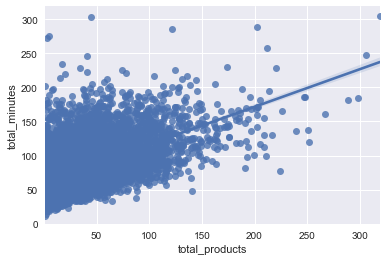

In [91]:
# Total products vs total minutes
sns.regplot(x="total_products", y="total_minutes", data=df)
plt.ylim(0,)

(0.0, 318.801343536667)

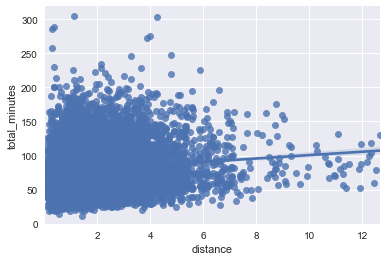

In [92]:
# Distance vs total minutes
sns.regplot(x="distance", y="total_minutes", data=df)
plt.ylim(0,)

<p> Se puede apreciar que en los dos gráficos anteriores eciste una relación lineal entre ambas varianles, sin embargo es mucho más marcada y clara en el primer gráfico que compara total products y total time, lo que tiene mucho sentido con lo visto en la matriz de correlación, donde esta tiene una magnitud de 0.54.  </p>

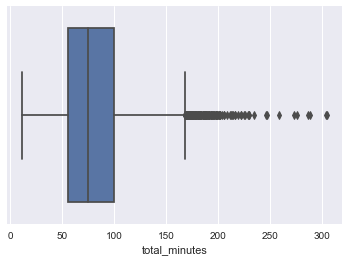

In [93]:
# Boxplot total minutes
sns.boxplot(x="total_minutes", data=df)

<p> Se puede notar que la mediana está en 74.7 minutos y que hay valores outliers, sin embargo preferimos no sacarlos y luego utilizar una métrica a la hora de evaluar predicciones que logre hacerse cargo de estos valores.  </p>

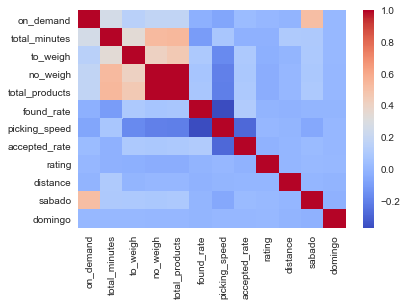

In [95]:
# Correlation Matrix
df_corr = df.corr()
sns.heatmap(df_corr,  cmap='coolwarm', fmt='.2f')

<p> Como ya lo hicimos anteriormente se construye una matriz de correlación esta vez con un formato más visual, se puede notar nuevamente que la variable más influyente en total minutes, la variable a predecir, es la variable total products.  </p>

In [96]:
df.isnull().any()

order_id          False
on_demand         False
total_minutes     False
to_weigh          False
no_weigh          False
total_products    False
found_rate        False
picking_speed     False
accepted_rate     False
rating            False
distance          False
sabado            False
domingo           False
dtype: bool

<p> Finalmente vemos que no hay missing values, lo cual es importante a la hora de entrenar los modelos de ML.  </p>

<h1> 5. Proposed Predictive Models </h1>

<p>En esta sección, primero se generan los conjuntos necesario para entrenar los modelos, estos son los conjuntos de testeo y de entrenamiento para poder utilizar cross validation y así obtener mejores predicciones con esta técnica.

Posteriormente se ajustaran los modelos. Los modelos propuestos son los siguientes:</p>

<li> Multiple linear regression </li>
<li> Random Forest </li>

<p>Las métricas a utilizar serán MAE y RMSE que son métricas que se utilizan frecuentemente en estos casos para medir de buena forma los errores de predicción. </p>



<h3> 5.1 Preparation Data </h3>

In [103]:
# Creating variables X e Y

x_1 = df.drop(columns=['total_minutes','to_weigh','no_weigh','accepted_rate','rating','order_id']) # remove order_id column and target
x_2=df.drop(columns=['total_minutes','total_products','order_id'])
y = df['total_minutes']

In [104]:
# Partitioning the data first model. Test Size=0.2

x_train1, x_test1, y_train1, y_test1 = train_test_split(x_1, y, test_size=0.2, random_state=1)
print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])

number of test samples : 1597
number of training samples: 6386


In [105]:
# Partitioning the data second model. Test Size=0.2

x_train2, x_test2, y_train2, y_test2 = train_test_split(x_2, y, test_size=0.2, random_state=1)
print("number of test samples :", x_test2.shape[0])
print("number of training samples:",x_train2.shape[0])

number of test samples : 1597
number of training samples: 6386


In [106]:
# Scaling the data

sc_x=StandardScaler()
x_train1=sc_x.fit_transform(x_train1)
x_test1=sc_x.fit_transform(x_test1)
x_train2=sc_x.fit_transform(x_train2)
x_test2=sc_x.fit_transform(x_test2)

<p> Se crean dos conjuntos de variables explicativas en el primero se sacan las variables to weigh y no weoigh ya que son redundantes con la variable total products, sacamos rating y accepted rate que son las variables que menos influencia tienen en total minutes según la matriz de correlación vista en la sección anterior.

En el segundo conjunto de variables explicativas se consevan todas las variables y se excluye total products para que no sean reduddantes con las variables weigh y no weigh.

Se decide dejar un 20% de la data para testeo. Y se escala la data para poder ajustar de mejor forma los modelos propuestos. </p>

<h3> 5.2 Multiple Linear Regression </h3>

In [107]:
# Ajust first model

lre=LinearRegression()
lre1=lre.fit(x_train1, y_train1)

print("R2 de modelo 1 es igual a ",lre.score(x_train1, y_train1))

# Predictions
time_pred1_lr = lre1.predict(x_test1)


R2 de modelo 1 es igual a  0.3742588264496325


In [109]:
# Error predicctios first model

mae1 = mean_absolute_error(y_test1, time_pred1_lr)
rmse1 = np.sqrt(mean_squared_error(y_test1, time_pred1_lr))
print("MAE del modelo lr 1 es: ", mae1)
print("RMSE del modelo lr 1 es: ", rmse1)

MAE del modelo lr 1 es:  20.67329782752329
RMSE del modelo lr 1 es:  26.267437235709632


In [110]:
# Adjust second model

lre2=lre.fit(x_train2, y_train2)
print("R2 de modelo 2 es igual a ",lre2.score(x_train2, y_train2))
# Predictions
time_pred2_lr = lre2.predict(x_test2)

R2 de modelo 2 es igual a  0.38734691322502623


In [111]:
# Error predicctios second model

mae2 = mean_absolute_error(y_test2, time_pred2_lr)
rmse2 = np.sqrt(mean_squared_error(y_test2, time_pred2_lr))
print("MAE del modelo lr 2 es: ", mae2)
print("RMSE del modelo lr 2 es: ", rmse2)

MAE del modelo lr 2 es:  20.353211069786433
RMSE del modelo lr 2 es:  25.78025974393172


<p> El segundo modelo posse un R^2 de 0.387 siendo mayor que el primero, lo cual quiere decir que explica de mejor forma la varianza de la data. Además, podemos observar que el segundo modelo posee tanto un menor MAE como un menor RMSE lo que nos permite afirmar que posee un mayor poder predictivo que el primer modelo. </p>

<h3> 5.3 Random Forest </h3>

In [112]:
# Adjust first model Random Forest 

rf=RandomForestRegressor()
rf1=rf.fit(x_train1, y_train1)

# Predictions
time_pred1_rf = rf1.predict(x_test1)

# Model errors

mae_rf1 = mean_absolute_error(y_test1, time_pred1_rf)
rmse_rf1 = np.sqrt(mean_squared_error(y_test1, time_pred1_rf))

print("MAE del modelo RF 1 es: ", mae_rf1)
print("RMSE del modelo RF 1 es ", rmse_rf1)


MAE del modelo RF 1 es:  20.836070088452928
RMSE del modelo RF 1 es  26.36885447346401


In [116]:
# Adjust second model Random Forest 

rf2=rf.fit(x_train2, y_train2)

# Predictions
time_pred2_rf = rf2.predict(x_test2)

# Model errors

mae_rf2 = mean_absolute_error(y_test2, time_pred2_rf)
rmse_rf2 = np.sqrt(mean_squared_error(y_test2, time_pred2_rf))

print("MAE del modelo RF 2 es: ", mae_rf2)
print("RMSE del modelo RF 2 es ", rmse_rf2)

MAE del modelo RF 2 es:  20.61528857957326
RMSE del modelo RF 2 es  26.044927445367275


<p> Para este tipo de modelos, podemos ver que el primer modelo tiene un más bajo MAE, mientars que el segundo tiene menor RMSE. Dada las condiciones de este modelo, donde hay outliers que no extrajimos de total minutes para no manipular tanto la data, nos quedaremos con el MAE pues se hace cargo de mejor forma de este tipo de datos excepcionales. Con lo anteriormente descrito el mejor modelo de ambos es el segundo con MAE de 20.615.  </p>

<h1> 6. Results </h1>

<p> De los 4 modelos corridos, dos en random forest y dos en regresión lineal, de los 4 modelos el que mejor predice y que por consecuencia tiene menor MAE es el segundo modelo de regresión lineal con un MAE de 20.352, mientras que el modelo que le sigue es el primero de la regresión lineal multiple con un MAE de 20.67 En esta sección guardaremos con un csv las predicciones del mejor modelo encontrado.  </p>

In [124]:
# Scaling complete data

sc_x=StandardScaler()
x_2S=sc_x.fit_transform(x_2)

In [130]:
# Predictions complete data

best_pred = lre2.predict(x_2S)

In [131]:
# Adding prediction column  total_minutes_pred

x_2['total_minutes_pred']=best_pred

In [132]:
#Adding real total minutes for comparation

x_2['total_minutes_real']=y


In [133]:
# Exporting dataframe with prediciton

x_2.to_csv('data1/Predictions_best_model', header=True, index=False)

In [134]:
# Load file
predictions = pd.read_csv('data1/Predictions_best_model', sep=',')
predictions.head()

,on_demand,to_weigh,no_weigh,found_rate,picking_speed,accepted_rate,rating,distance,sabado,domingo,total_minutes_pred,total_minutes_real
0,0,4,16.0,0.9024,1.30,0.92,4.76,0.606291,0,0,61.625746,67.684264
1,0,4,63.0,0.9024,1.30,0.92,4.76,0.872726,1,0,82.517758,160.336211
2,1,1,155.0,0.8909,1.17,0.96,5.00,1.685322,1,0,135.874927,122.239210
3,1,8,115.0,0.8462,1.11,0.96,4.96,0.766170,1,0,135.306734,133.113926
4,1,3,97.0,0.8138,1.89,0.84,4.68,3.096363,1,0,130.843043,94.734479


<h1>7. Conclusions </h1>

<p> Una vez concluido el trabajo se dejan algunas conclusiones claves y mejoras propuesta para el trabajo realizado en el presente archivo. Las mejoras están netamente enfocadas a generar un mejor ajuste que el logrado en el presente trabajo. Las conclusiones y mejoras propuestas son las siguientes:  </p>

<li> En el análisis exploratorio vimos que las variables que mayor influencia tienen en el total de minuto son el total de productos, la distancia entre el cliente y el branch.  Me parece que dada la influencia de la distancia en el tiempo total, debería incluirse la distancia desde la posición en el que el shopper toma el pedido para poder predecir e incluir en las variables explicatovas este tiempo. </li>

<li>El mejor modelo obtenido en el presente trabajo, es decir, el que mostó menores diferencias entre el tiempo predecido y el tiempo real fue la regresión lineal del segundo modelo obteniendo un MAE de 20.35. </li>

<li> Se propone con más tiempo explorar otros modelos de Machine learning como SVM o redes neuronales y ver si con estos se logra obtener un MAE aún más bajo.</li>

<li> Otra recomendación importante consiste en segmentar el problema y estimar los distintos tiempos por separado, esto debería ajustar mejor, es de cir, calcular el picking time, el cual estará muy correlacionado al branch, el día y la cantidad de producto. Y por otro lado calcular el delivery time, que estará. correlacionado con la distancia entre el branch y el ciente, la congestión que a su vez podría estar muy correlacionada con el día</li>



